In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import os
sns.set_style('white')

In [2]:
print(os.listdir('../datasets/mnist3d/'))

['full_dataset_vectors.h5', 'plot3D.py', 'test_point_clouds.h5', 'train_point_clouds.h5', 'voxelgrid.py']


In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

with h5py.File('../datasets/mnist3d/full_dataset_vectors.h5','r') as dataset:
    X_train, X_test = dataset['X_train'][:],dataset['X_test'][:]
    y_train, y_test = dataset['y_train'][:],dataset['y_test'][:]
    
print('Train shape:', X_train.shape)
print('Train label:', y_train.shape)
print('Test shape:', X_test.shape)
print('Test label:', y_test.shape)

def array_to_color(array, cmap = 'Oranges'):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]
def translate(x):
    xx = np.ndarray((x.shape[0], 4096, 3))
    for i in range(x.shape[0]):
        xx[i] = array_to_color(x[i])
        if i % 1000 == 0:
            print(i)
    del x
    return xx

X_train = translate(X_train).reshape(-1,16,16,16,3)
X_test = translate(X_test).reshape(-1,16,16,16,3)
y_train = to_categorical(y_train,num_classes=10)

Train shape: (10000, 4096)
Train label: (10000,)
Test shape: (2000, 4096)
Test label: (2000,)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000


In [4]:
y_test = to_categorical(y_test,num_classes=10)

### Translate data to fed in 3d CNN

In [5]:
X_train.shape

(10000, 16, 16, 16, 3)

In [6]:
len(X_train)

10000

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout, Flatten,Conv3D, MaxPool3D,BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau,TensorBoard

def build_model(input_shape,num_classes):
    model = Sequential()

    model.add(Conv3D(8, (3,3,3), input_shape=input_shape))
    model.add(Conv3D(16, (3,3,3)))
    # model.add(BatchNormalization())
    model.add(MaxPool3D())
    # model.add(Dropout(0.25))

    model.add(Conv3D(32, (3,3,3)))
    model.add(Conv3D(64, (3,3,3)))
    model.add(BatchNormalization())
    model.add(MaxPool3D())
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

In [8]:
model = build_model((16,16,16,3),10)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 14, 14, 14, 8)     656       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 12, 12, 16)    3472      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 6, 6, 16)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 4, 4, 32)       13856     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 2, 64)       256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 1, 1, 64)       0

In [11]:
model.compile(optimizer ='rmsprop', loss ='categorical_crossentropy', metrics = ['accuracy'])

In [109]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

filepath = '../HandGestureRecognitionUsingMnistDataset/bestweight.h5'
mcp = ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)

earlystop = EarlyStopping(monitor ='val_loss',patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1,verbose=0,mode='auto',min_lr=0.00001)


In [110]:
batch_size = 132
epoch = 50
history = model.fit(x=X_train,y=y_train,batch_size=batch_size,epochs=epoch,validation_split = 0.20,verbose=1,callbacks=[earlystop,reduce_lr,mcp])

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
7920/8000 [============================>.] - ETA: 0s - loss: 0.9507 - accuracy: 0.6596
Epoch 00001: val_loss improved from inf to 2.83629, saving model to ../HandGestureRecognitionUsingMnistDataset/bestweight.h5
8000/8000 [==============================] - 37s 5ms/sample - loss: 0.9496 - accuracy: 0.6600 - val_loss: 2.8363 - val_accuracy: 0.4435
Epoch 2/50
7920/8000 [============================>.] - ETA: 0s - loss: 0.9467 - accuracy: 0.6660
Epoch 00002: val_loss improved from 2.83629 to 2.50463, saving model to ../HandGestureRecognitionUsingMnistDataset/bestweight.h5
8000/8000 [==============================] - 35s 4ms/sample - loss: 0.9453 - accuracy: 0.6662 - val_loss: 2.5046 - val_accuracy: 0.5445
Epoch 3/50
7920/8000 [============================>.] - ETA: 0s - loss: 0.9425 - accuracy: 0.6665
Epoch 00003: val_loss improved from 2.50463 to 1.47832, saving model to ../HandGestureRecognitionUsingMnistDataset/bestweight.h5
800

7920/8000 [============================>.] - ETA: 0s - loss: 0.9151 - accuracy: 0.6707
Epoch 00027: val_loss did not improve from 0.98301
8000/8000 [==============================] - 34s 4ms/sample - loss: 0.9161 - accuracy: 0.6704 - val_loss: 0.9898 - val_accuracy: 0.6655
Epoch 28/50
7920/8000 [============================>.] - ETA: 0s - loss: 0.9180 - accuracy: 0.6657
Epoch 00028: val_loss improved from 0.98301 to 0.98063, saving model to ../HandGestureRecognitionUsingMnistDataset/bestweight.h5
8000/8000 [==============================] - 34s 4ms/sample - loss: 0.9158 - accuracy: 0.6670 - val_loss: 0.9806 - val_accuracy: 0.6715
Epoch 29/50
7920/8000 [============================>.] - ETA: 0s - loss: 0.9001 - accuracy: 0.6817
Epoch 00029: val_loss did not improve from 0.98063
8000/8000 [==============================] - 35s 4ms/sample - loss: 0.8991 - accuracy: 0.6820 - val_loss: 0.9966 - val_accuracy: 0.6645
Epoch 30/50
7920/8000 [============================>.] - ETA: 0s - loss: 0.9

In [124]:
history.history

{'loss': [0.9495854872763156,
  0.9453020444214344,
  0.9442794869244099,
  0.9469992652535438,
  0.9326776329278946,
  0.927093661993742,
  0.9302931317090988,
  0.9177526409327984,
  0.9227803989946842,
  0.9192880414426327,
  0.918408262938261,
  0.9237736931145191,
  0.914473569482565,
  0.920411417633295,
  0.906563556611538,
  0.9099333702921867,
  0.9086674618422985,
  0.9022282868027687,
  0.9097092979550362,
  0.9194321795701981,
  0.9041050127446651,
  0.9105350058674813,
  0.9165623835921287,
  0.9075232070088387,
  0.9125433737039566,
  0.9155936156213283,
  0.9160514540970326,
  0.9157912639379502,
  0.8990803453028202,
  0.9064038655459881,
  0.9154898245036602,
  0.912953162163496,
  0.9107190055251122,
  0.9067578064799309,
  0.8925557076632976,
  0.9190336818695068,
  0.904628861695528,
  0.9176390172541141],
 'accuracy': [0.66,
  0.66625,
  0.665625,
  0.660375,
  0.669,
  0.66875,
  0.667625,
  0.670875,
  0.674375,
  0.674,
  0.668,
  0.673375,
  0.67375,
  0.669125

In [113]:
results =model.evaluate(x= X_test, y= y_test,batch_size = 132)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [128]:

def plot(history):
   
    
    plt.figure(figsize = (10,5))
    
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label = 'Training Loss')
    plt.plot(history['val_loss'], label = 'Validation Loss')
    plt.title('Training and Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label = 'Training Accuracy')
    plt.plot(history['val_accuracy'], label = 'Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.show()
    

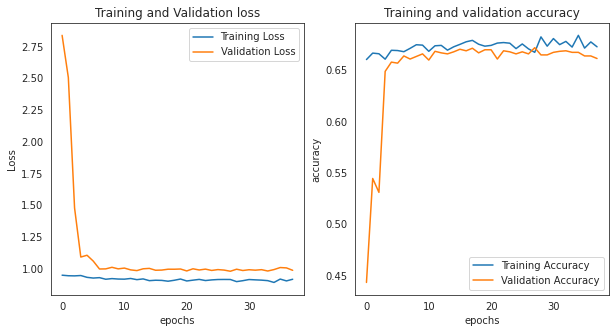

In [129]:
plot(history.history)

In [13]:
model.load_weights('../HandGestureRecognitionUsingMnistDataset/bestweight.h5')

In [1]:
pip install 'h5py<3.0.0'

     |████████████████████████████████| 2.9 MB 3.1 MB/s eta 0:00:01
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
Note: you may need to restart the kernel to use updated packages.


In [17]:
prediction = model.predict(X_test)

In [20]:
prediction = np.argmax(prediction,axis=1)

In [24]:
prediction

array([7, 7, 2, ..., 0, 9, 4])

In [26]:
y_test = np.argmax(y_test,axis=1)

In [27]:
y_test

array([7, 7, 2, ..., 8, 9, 9])

In [37]:
y_test[1:10]

array([7, 2, 2, 1, 1, 0, 0, 4, 4])

In [36]:
prediction[1:10]

array([7, 2, 5, 1, 1, 0, 0, 4, 2])

In [38]:
accuracy_score(y_test,prediction)

0.662

accuracy score: 0.662


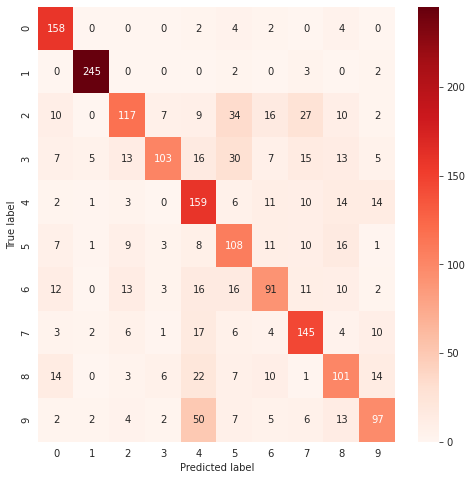

In [32]:
from sklearn.metrics import confusion_matrix,accuracy_score

def plot_confusion_matrix(model_name):
    # Predict the values from the validation dataset
    y_pred = model_name.predict(X_test)
    # Because Y_pred is an array of probabilities, we have to convert it to one hot vectors 
    y_pred = np.argmax(y_pred,axis = 1)
    #y_test = np.argmax(y_test,axis=1)
    #Compute and print the accuracy scores:
    print('accuracy score:', accuracy_score(y_test,y_pred))
    # compute the confusion matrix .
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm, index = range(10), columns = range(10))
    # plot the confusion matrix
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, cmap="Reds", annot=True, fmt='.0f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

plot_confusion_matrix(model)

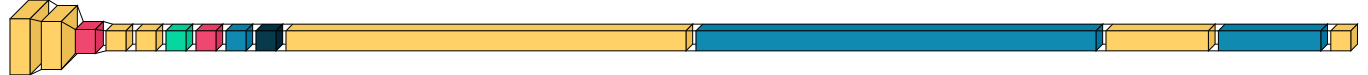

In [39]:
import visualkeras
visualkeras.layered_view(model)